In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
list = glob.glob("*.csv")
list

['us-counties.csv',
 'time_series_covid19_confirmed_global.csv',
 'us-states.csv']

In [3]:
data = pd.read_csv("us-counties.csv", parse_dates = ["date"])
data["level_cases"] = pd.cut(data.cases, 5, labels=[0, 1, 2, 3, 4])

In [4]:
data.head()

,date,county,state,fips,cases,deaths,level_cases
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,0
3,2020-01-24,Cook,Illinois,17031.0,1,0,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,0


In [5]:
from sklearn.preprocessing import MinMaxScaler
cl = MinMaxScaler()
X_t = cl.fit_transform(data[["cases"]])
data["cases_norm"] = X_t

In [6]:
#creating windows
def create_window(interval, data):
    X = []
    y = []
    groupby_county = data.groupby("county")
    county_list = data.county.unique()
    for county_ind in county_list:
        county = groupby_county.get_group(county_ind)
        county = county[["cases_norm", "level_cases"]]
        for i in range(county.shape[0]-interval-5):
            X.append(county.iloc[i:i+interval].values)
            y.append(county.iloc[i+interval:i+interval+5, -2].values)
            
    return np.array(X), np.array(y)

In [7]:
interval = 10
data_X, data_y = create_window(interval,data)

In [8]:
data_y.shape

(33968, 5)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=42)

In [10]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],2))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],2))

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

/Users/fatmimi/opt/anaconda3/envs/playground/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/fatmimi/opt/anaconda3/envs/playground/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/fatmimi/opt/anaconda3/envs/playground/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/fatmimi/o

In [12]:
#temporal input branch
input_layer = Input(shape=(13,1))
lstm_layer_1 = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(input_layer)
dense_layer = layers.Dense(64)(lstm_layer_1)
#dropout_layer = layers.Dropout(dense_layer)
covid_cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="cases")(dense_layer)

#Establish model
model = Model([input_layer], [covid_cases])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 13, 128)           66560     
_________________________________________________________________
dense (Dense)                (None, 13, 64)            8256      
_________________________________________________________________
cases (Dense)                (None, 13, 1)             65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

Instructions for updating:
Use tf.cast instead.


In [15]:
model_2 = Sequential()
model_2.add(layers.LSTM(128,input_shape=(interval,2)))
model_2.add(layers.Dense(64))
model_2.add(layers.Dropout(rate = 0.2))
model_2.add(layers.Dense(5))

In [16]:
model_2.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam')

In [17]:
history = model_2.fit(X_train, y_train, 
          epochs = 30, 
          batch_size = 1000, 
          validation_data=(X_test,  y_test), 
          callbacks=callbacks)

Train on 22758 samples, validate on 11210 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
22758/22758 [==============================] - 3s 137us/sample - loss: 1.0225e-04 - val_loss: 7.8646e-05
Epoch 2/30
22758/22758 [==============================] - 2s 86us/sample - loss: 7.5108e-05 - val_loss: 6.3708e-05
Epoch 3/30
22758/22758 [==============================] - 2s 84us/sample - loss: 6.5138e-05 - val_loss: 5.5951e-05
Epoch 4/30
22758/22758 [==============================] - 2s 85us/sample - loss: 5.6151e-05 - val_loss: 5.1106e-05
Epoch 5/30
22000/22758 [============================>.] - ETA: 0s - loss: 5.4320e-05
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
22758/22758 [==============================] - 2s 88us/sample - loss: 5.4145e-05 - val_loss: 5.0711e-05
Epoch 6/30
22758/22758 [==============================] - 2s 86us/sample - loss: 4.7748e-05 - val_loss: 4.4511e-05
Epoch 7/30
22758/22758 [==============================] -

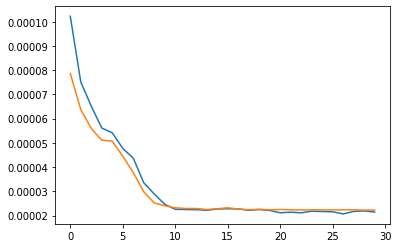

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

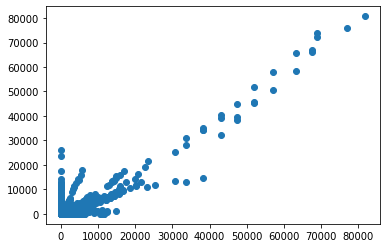

In [19]:
Xt = model_2.predict(X_test)
plt.scatter(cl.inverse_transform(y_test.reshape(-1,1)),cl.inverse_transform(Xt))

In [20]:
#Prepare Alachua data
Alachua = data.groupby('county').get_group('Alachua')
Alachua = Alachua[["cases_norm", "level_cases"]]
c = Alachua[-interval:].values.reshape(-1,2)
alas = c.reshape(1,interval,2)
alas
Ala = model_2.predict(alas)
Ala_rev = cl.inverse_transform(Ala).reshape(5)
Ala_rev

array([179.06653, 192.75546, 205.5717 , 228.79881, 242.60234],
      dtype=float32)

In [21]:
r = [1,2,3,4,5]
for s in zip(r, Ala_rev):
    print([s[0],s[1]])

[1, 179.06653]
[2, 192.75546]
[3, 205.5717]
[4, 228.79881]
[5, 242.60234]


In [22]:
a = data.query("county == 'Alachua'")

In [23]:
import datetime
day = []
for i in range(0,5):
    n = a.date.iloc[-1] + datetime.timedelta(days=i)
    day.append(n)
day

[Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-16 00:00:00'),
 Timestamp('2020-04-17 00:00:00')]

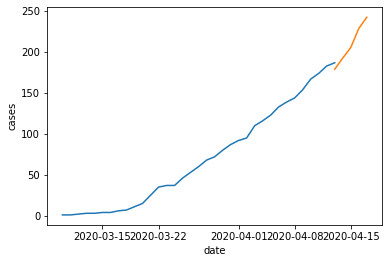

In [24]:
sns.lineplot(a.date, a.cases)
sns.lineplot(day,Ala_rev.reshape(5))